In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-sales-dataset/amazon_sales_dataset.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [3]:
df=pd.read_csv("/kaggle/input/amazon-sales-dataset/amazon_sales_dataset.csv");
print(df.head())

   order_id  order_date  product_id product_category   price  \
0         1  2022-04-13        2637            Books  128.75   
1         2  2023-03-12        2300          Fashion  302.60   
2         3  2022-09-28        3670           Sports  495.80   
3         4  2022-04-17        2522            Books  371.95   
4         5  2022-03-13        1717           Beauty  201.68   

   discount_percent  quantity_sold customer_region payment_method  rating  \
0                10              4   North America            UPI     3.5   
1                20              5            Asia    Credit Card     3.7   
2                20              2          Europe            UPI     4.4   
3                15              4     Middle East            UPI     5.0   
4                 0              4     Middle East            UPI     4.6   

   review_count  discounted_price  total_revenue  
0           443            115.88         463.52  
1           475            242.08        1210.40  

In [4]:
df['order_date'] = pd.to_datetime(df['order_date'])
weekly_df = df.groupby(
    pd.Grouper(key='order_date', freq='W')
).agg({
    'total_revenue': 'sum',
    'quantity_sold': 'sum',
    'discount_percent': 'mean',
    'price': 'mean',
    'rating': 'mean',
    'review_count': 'sum'
}).reset_index()


In [5]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(weekly_df.drop('order_date', axis=1))


In [6]:


def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback, 0])  # total_revenue index
    return np.array(X), np.array(y)
lookback = 12
X, y = create_sequences(scaled_data, lookback)

print(X.shape)
print(y.shape)



(93, 12, 6)
(93,)


In [7]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


2026-02-11 17:25:31.254922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770830731.462822      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770830731.525622      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770830732.027373      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770830732.027456      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770830732.027459      17 computation_placer.cc:177] computation placer alr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[es]
)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.5968 - val_loss: 0.0305
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0273 - val_loss: 0.0902
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0683 - val_loss: 0.0215
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0134 - val_loss: 0.0091
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0181 - val_loss: 0.0184
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0204 - val_loss: 0.0075
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0084 - val_loss: 0.0056
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0068 - val_loss: 0.0135
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0120 - val_loss: 0.0065
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0073 - val_loss: 0.0038
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0072 - val_loss: 0.0039
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0058 - val_l

In [10]:
y_pred = model.predict(X_test)

# Create dummy array for inverse scaling
dummy = np.zeros((len(y_pred), scaled_data.shape[1]))
dummy[:, 0] = y_pred[:, 0]

y_pred_inv = scaler.inverse_transform(dummy)[:, 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


In [11]:
# Inverse scale y_test
dummy_actual = np.zeros((len(y_test), scaled_data.shape[1]))
dummy_actual[:, 0] = y_test

y_test_inv = scaler.inverse_transform(dummy_actual)[:, 0]


In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))


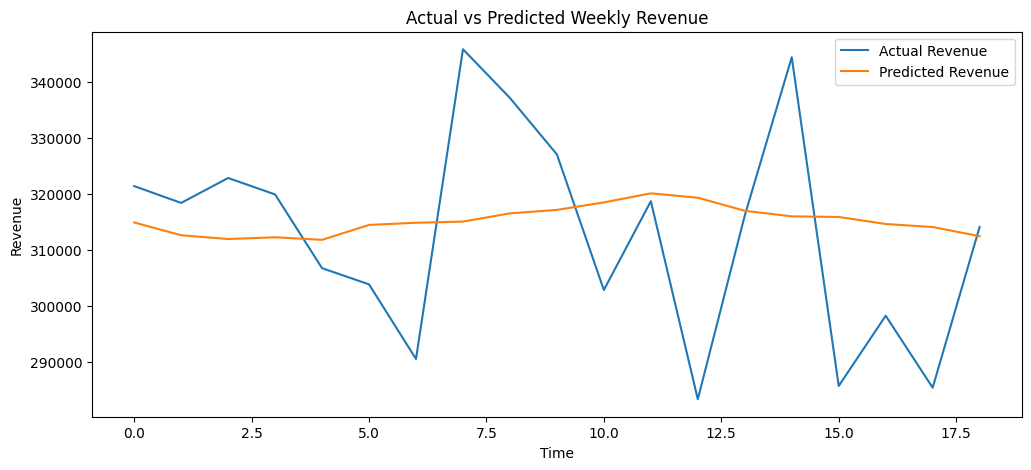

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual Revenue')
plt.plot(y_pred_inv, label='Predicted Revenue')
plt.title('Actual vs Predicted Weekly Revenue')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.legend()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


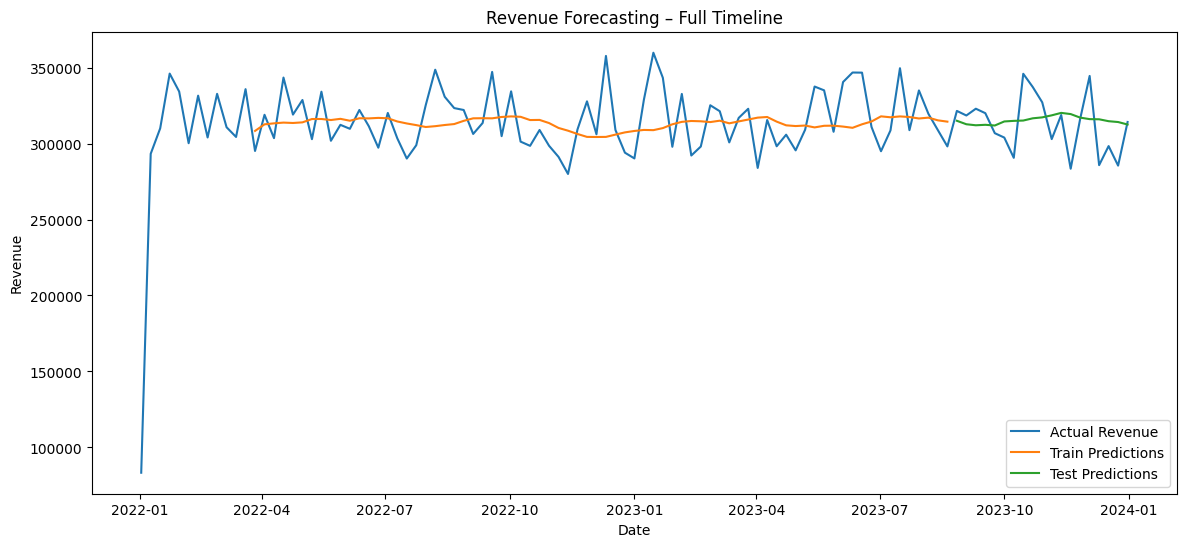

In [14]:
train_predictions = model.predict(X_train)

# Inverse scale train predictions
dummy_train = np.zeros((len(train_predictions), scaled_data.shape[1]))
dummy_train[:, 0] = train_predictions[:, 0]
train_pred_inv = scaler.inverse_transform(dummy_train)[:, 0]

plt.figure(figsize=(14,6))
plt.plot(weekly_df['order_date'], weekly_df['total_revenue'], label='Actual Revenue')

plt.plot(
    weekly_df['order_date'][lookback:split+lookback],
    train_pred_inv,
    label='Train Predictions'
)

plt.plot(
    weekly_df['order_date'][split+lookback:],
    y_pred_inv,
    label='Test Predictions'
)

plt.title('Revenue Forecasting – Full Timeline')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()
